# 17 · Detección de esquinas con **Harris**


## 1) Idea (resumen)
El detector de **Harris** evalúa la variación de la intensidad al desplazar una ventana alrededor de cada píxel.
Formalmente, a partir de las derivadas \(I_x, I_y\) se construye la **matriz de estructura** (matriz de segundo momento) por ventana:
\[
M = \begin{bmatrix}
\sum w I_x^2 & \sum w I_x I_y \\
\sum w I_x I_y & \sum w I_y^2
\end{bmatrix}
\]
y la **respuesta de Harris** típica es:
\[
R = \det(M) - k \, (\mathrm{trace}(M))^2,
\]
donde \(k \in [0.04,\,0.06]\) usualmente.

- **Mapa de variación**: el mapa de \(R\) (valores grandes indican esquina).
- **Supresión de no-máximos**: se conservan solo picos locales de \(R\) por encima de un umbral.


## 2) Código

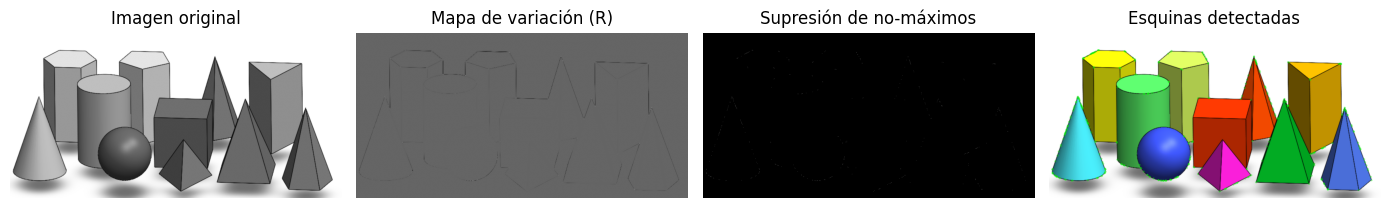

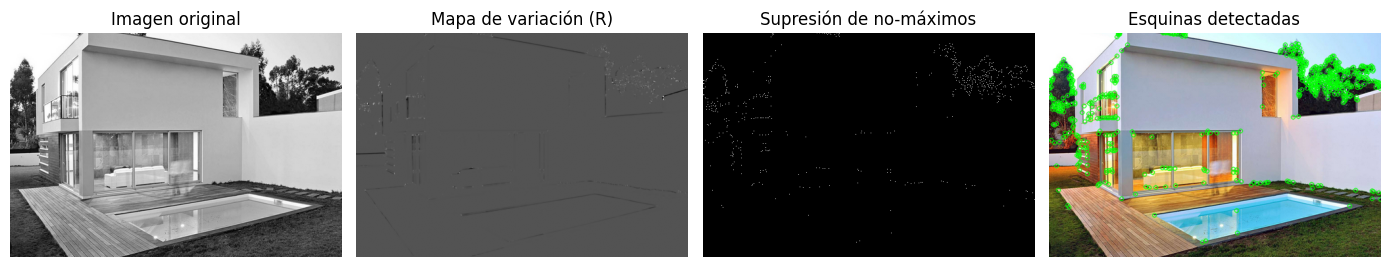

In [6]:
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# --- Configura aquí tus rutas ---
IMG_PATH_1 = r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\figuras.png"   # Primer imagen (gris o color)
IMG_PATH_2 = r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\casa.png"  # segunda imagen s (gris o color)

# Parámetros de Harris
blockSize = 2   # tamaño de vecindad para el cálculo de la matriz M
ksize     = 3   # tamaño del Sobel usado internamente (derivadas)
k         = 0.04  # parámetro de Harris
thresh_rel = 0.02 # fracción del máximo de R para umbral (ajusta 0.01–0.05)

def load_gray(path):
    bgr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if bgr is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen en {path}")
    if bgr.ndim == 3:
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    else:
        gray = bgr
        rgb  = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    return gray, rgb

def harris_response(gray, blockSize=2, ksize=3, k=0.04):
    gray_f32 = np.float32(gray)
    R = cv2.cornerHarris(gray_f32, blockSize, ksize, k)
    return R

def non_max_suppression(R, thresh_rel=0.02):
    # Umbral relativo al máximo
    t = R.max() * float(thresh_rel)
    # Dilatación para hallar máximos locales
    R_dil = cv2.dilate(R, None)
    # Igualdad exacta en float puede ser sensible; usamos >= y un pequeño margen
    maxima = (R >= R_dil) & (R > t)
    return maxima

def overlay_corners(rgb, maxima, radius=3, color=(0,255,0), thickness=1):
    out = rgb.copy()
    ys, xs = np.where(maxima)
    for (x,y) in zip(xs, ys):
        cv2.circle(out, (int(x), int(y)), radius, color, thickness, lineType=cv2.LINE_AA)
    return out

def panel_for_image(gray, rgb, title_prefix=""):
    # 1) Respuesta Harris
    R = harris_response(gray, blockSize, ksize, k)
    # Normalizamos para visualización
    R_norm = cv2.normalize(R, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    R_norm_u8 = R_norm.astype(np.uint8)

    # 2) No-máximos
    maxima = non_max_suppression(R, thresh_rel)

    # 3) Overlay de esquinas
    over = overlay_corners(rgb, maxima)

    # 4) Mostrar fila: original, mapa R, NMS, overlay
    fig, axs = plt.subplots(1, 4, figsize=(14,3.2))
    axs[0].imshow(gray, cmap='gray'); axs[0].set_title(f"{title_prefix}Imagen original"); axs[0].axis('off')
    axs[1].imshow(R_norm_u8, cmap='gray'); axs[1].set_title("Mapa de variación (R)"); axs[1].axis('off')
    axs[2].imshow(maxima.astype(np.uint8)*255, cmap='gray'); axs[2].set_title("Supresión de no-máximos"); axs[2].axis('off')
    axs[3].imshow(over); axs[3].set_title("Esquinas detectadas"); axs[3].axis('off')
    plt.tight_layout()
    plt.show()

# --- Procesar primera imagen ---
gray1, rgb1 = load_gray(IMG_PATH_1)
panel_for_image(gray1, rgb1, title_prefix="")

# --- Procesar segunda imagen si existe ---
if IMG_PATH_2 and Path(IMG_PATH_2).exists():
    gray2, rgb2 = load_gray(IMG_PATH_2)
    panel_for_image(gray2, rgb2, title_prefix="")

### Notas
- Ajusta **`thresh_rel`** para controlar cuántos puntos sobreviven tras la NMS (0.01–0.05 suele ir bien).
- **`blockSize`** controla el tamaño de la ventana del momento segundo; **`ksize`** el kernel del Sobel interno.
- Los resultados pueden mejorar si se suaviza ligeramente la imagen con `GaussianBlur` antes de `cornerHarris`.
